When data is normal we use - Parametric Test which is done on mean as it is the central point.

When data is not normal (skewed) we use - Non-Parametric Test which is done on Median as it is the central point

# Problem Statement

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

In [275]:
import math
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             classification_report, confusion_matrix, f1_score,
                             mean_squared_error, precision_score, recall_score,
                             roc_auc_score)
from sklearn.preprocessing import Binarizer, LabelEncoder, StandardScaler
from statsmodels.tools import add_constant as ac
from xgboost import XGBClassifier

sc = StandardScaler()
le = LabelEncoder()

from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.under_sampling import NearMiss
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              RandomForestClassifier, RandomForestRegressor)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (GridSearchCV, KFold, RandomizedSearchCV,
                                     StratifiedKFold, cross_val_score,
                                     train_test_split)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

rfr = RandomForestRegressor()
rfc = RandomForestClassifier()
import warnings

warnings.filterwarnings('ignore')
from sklearn.svm import SVC
from statsmodels.formula.api import ols

In [276]:
train = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [277]:
for i in train.columns:
    if i not in test.columns:
        target_var = i
        print(target_var)

Survived


In [278]:
def outlier_red(df, x):

    # ul = df[x].mean() + 3*df[x].std()
    # ll = df[x].mean() - 3*df[x].std()
    # # print(df[x].describe())

    # # print(ul)
    # # print(ll)
    # df[x] = np.where(
    #     df[x]>ul,
    #     ul,
    #     np.where(
    #         df[x]<ll,
    #         ll,
    #         df[x]
    #     )
    # )

    # Using BoxPlot Method
    perc25 = df[x].quantile(0.25)
    perc75 = df[x].quantile(0.75)

    iqr = perc75 - perc25

    ul = perc75 + 1.5 * iqr
    ll = perc25 - 1.5 * iqr

    df[x] = np.where(
        df[x]>ul,
        ul,
        np.where(
            df[x]<ll,
            ll,
            df[x]
        )
    )

    return df[x]

In [279]:
def check_multicol(x):
    plt.figure(figsize=(20, 10))
    sns.heatmap(x.corr(), annot=True)
    plt.show()

In [280]:
# This function would return the last created submission file with the name 
# provided(x), so that the next submission file would be named with the next 
# number automatically. 
# Like Sub1, Sub2.  

def ret_latest_file(x):
    ans = os.listdir()
    finlist = []
    re_pat = re.compile("([a-zA-Z]+)([0-9]+)")
    for i in ans:
        try:            
            if i[-3:] == 'csv':
                res = re_pat.match(i).groups()     #type: ignore            
                if res[0] == x:
                    finlist.append(int(res[1]) + 1)            
        except:
            pass
    if len(finlist) > 0:
        return res[0], max(finlist) #type: ignore
    else:
        return x, 0

In [281]:
train[target_var] = train[target_var].astype('category')

# Converting target into Categorical

In [282]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    category
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    object  
 5   Age          714 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float64 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    object  
dtypes: category(1), float64(2), int64(4), object(5)
memory usage: 77.7+ KB


In [283]:
combined = pd.concat([train, test], sort = False, ignore_index=True)

In [284]:
combined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [285]:
# Preparing Data for submission

def sub(n, pred):
    name, num = ret_latest_file(n)
    sol = pd.read_csv('./Data/gender_submission.csv')
    sol.loc[:, target_var] = pred #type: ignore
    sol.to_csv(f'./Submissions/{name}_{num+1}.csv', index=False)


In [286]:
# Base Submission

# sub('base', 0)

In [287]:
to_be_cat = ['Pclass', 'SibSp', 'Parch']
combined[to_be_cat] = combined[to_be_cat].astype('category')

In [288]:
for i in combined.select_dtypes('object'):
    combined[i] = combined[i].astype('category')

In [289]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1309 non-null   int64   
 1   Survived     891 non-null    category
 2   Pclass       1309 non-null   category
 3   Name         1309 non-null   category
 4   Sex          1309 non-null   category
 5   Age          1046 non-null   float64 
 6   SibSp        1309 non-null   category
 7   Parch        1309 non-null   category
 8   Ticket       1309 non-null   category
 9   Fare         1308 non-null   float64 
 10  Cabin        295 non-null    category
 11  Embarked     1307 non-null   category
dtypes: category(9), float64(2), int64(1)
memory usage: 134.9 KB


In [290]:
combined.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### EDA: Univariate Analysis

In [291]:
not_plot = ['PassengerId', 'Name', 'Ticket', 'Cabin']
color = ['red','blue','green']

In [292]:
def univariate(df = combined, rows = 4, cols = 4):
    k = 0
    fig=plt.figure(figsize=(20,20))
    for i in df.columns:
        if i not in not_plot:
            if i in df.select_dtypes(['category', 'object']).columns:
                ax=fig.add_subplot(rows,cols,k+1)
                sns.countplot(x= i, data = df, ax=ax)
                plt.xticks(rotation = 45)
                k += 1
            if i in df.select_dtypes(['int', 'float']).columns:
                ax=fig.add_subplot(rows,cols,k+1)
                sns.distplot(x = df[i], ax=ax, color=np.random.choice(color))
                ax.set(xlabel=i)
                k += 1
    fig.tight_layout() 
    plt.show()

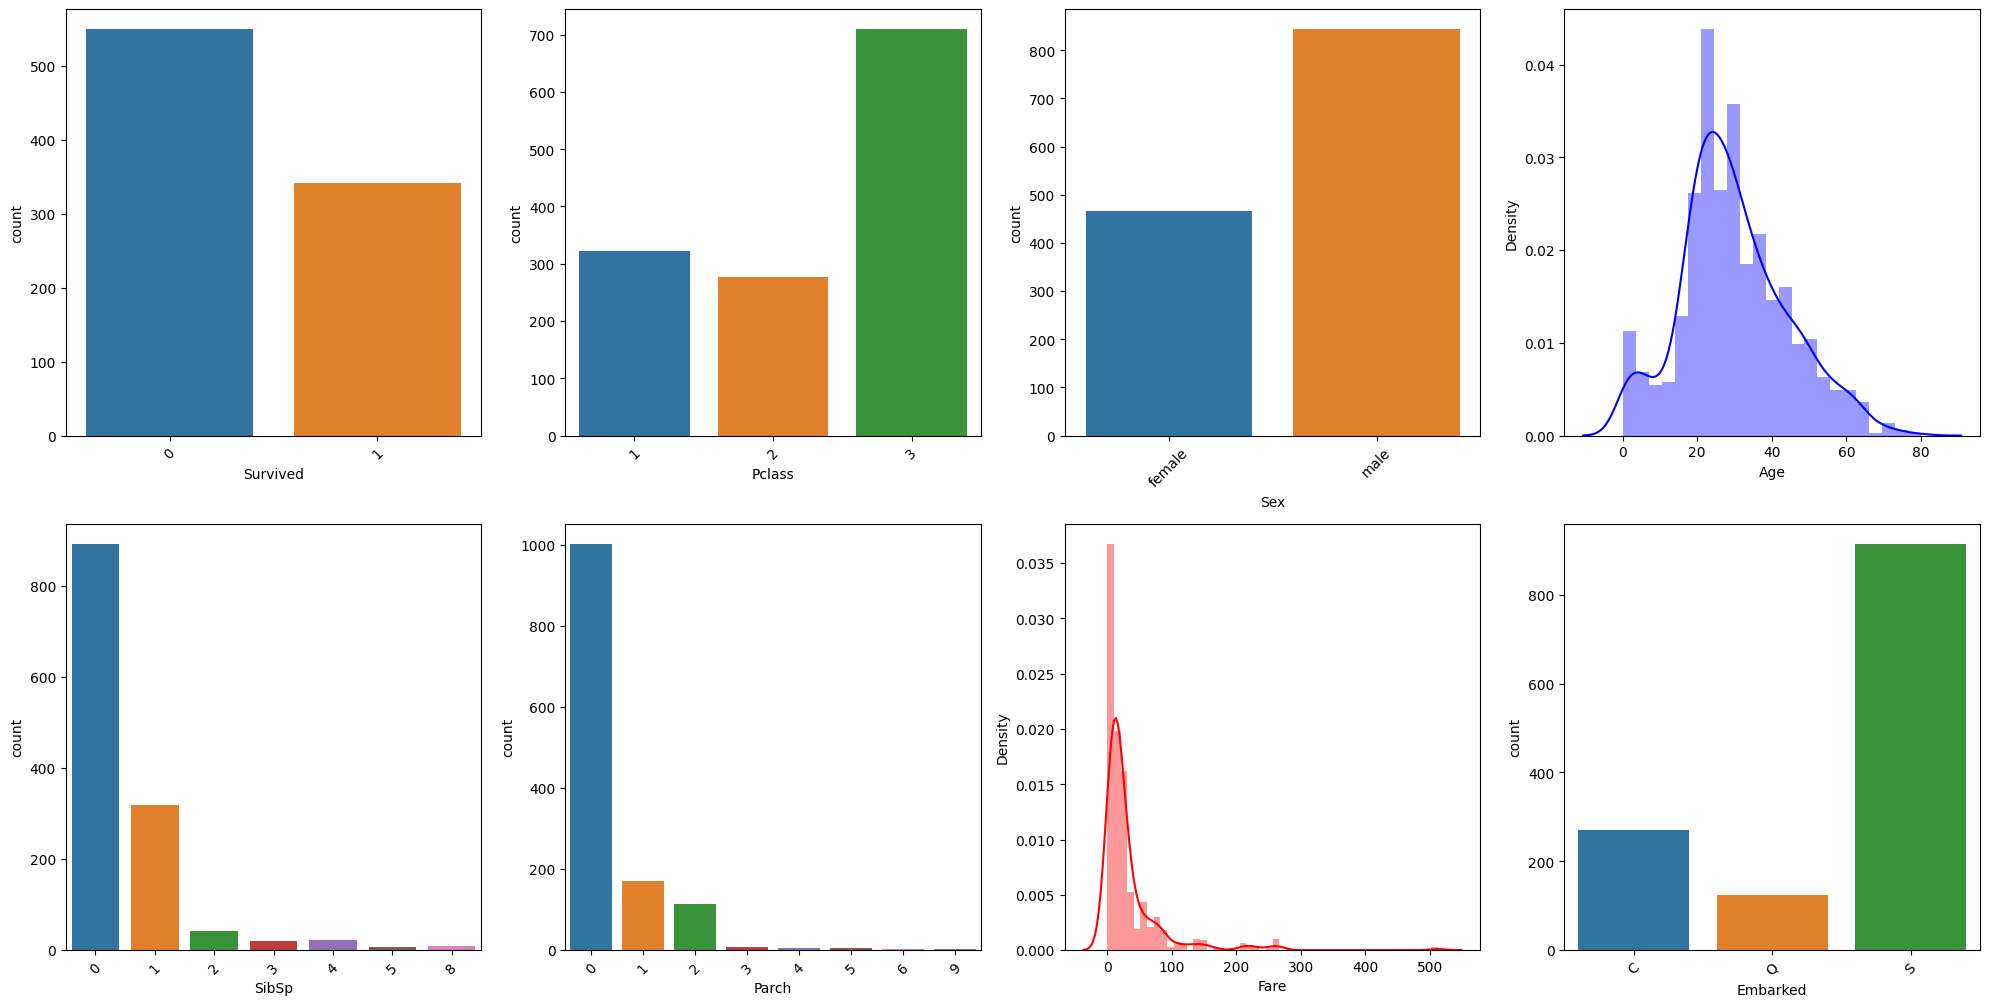

In [293]:
univariate(combined)

### EDA: Bivariate Analysis

In [294]:
def bivariate(df = combined, y = target_var, cols = 3, rows = 3):
    temp = not_plot[:] 
    temp.append(str(y))
    k = 0
    fig=plt.figure(figsize=(25,20))

    for i in df.columns:
        if i not in temp:
            if y in df.select_dtypes(['float', 'int']):
                if i in df.select_dtypes(['category', 'object']):
                    if (i not in temp): 
                        ax=fig.add_subplot(rows,cols,k+1)
                        sns.boxplot(x = i, y = y, data = df)

                if i in df.select_dtypes(['float', 'int']):                
                    if (i not in temp):      
                        ax=fig.add_subplot(rows,cols,k+1)       
                        sns.scatterplot(x = y, y = i, data = df)                  
                k += 1
            elif y in df.select_dtypes(['category', 'object']):
                if i in df.select_dtypes(['category', 'object']):
                    if (i not in temp):
                        ax=fig.add_subplot(rows,cols,k+1)
                        sns.countplot(x = i, hue = y, data = df)
                        plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

                if i in df.select_dtypes(['float', 'int']):
                    if (i not in temp):
                        ax=fig.add_subplot(rows,cols,k+1)
                        sns.boxplot(x = y, y = i, data = df)
                k += 1
    fig.tight_layout() 
    plt.show()

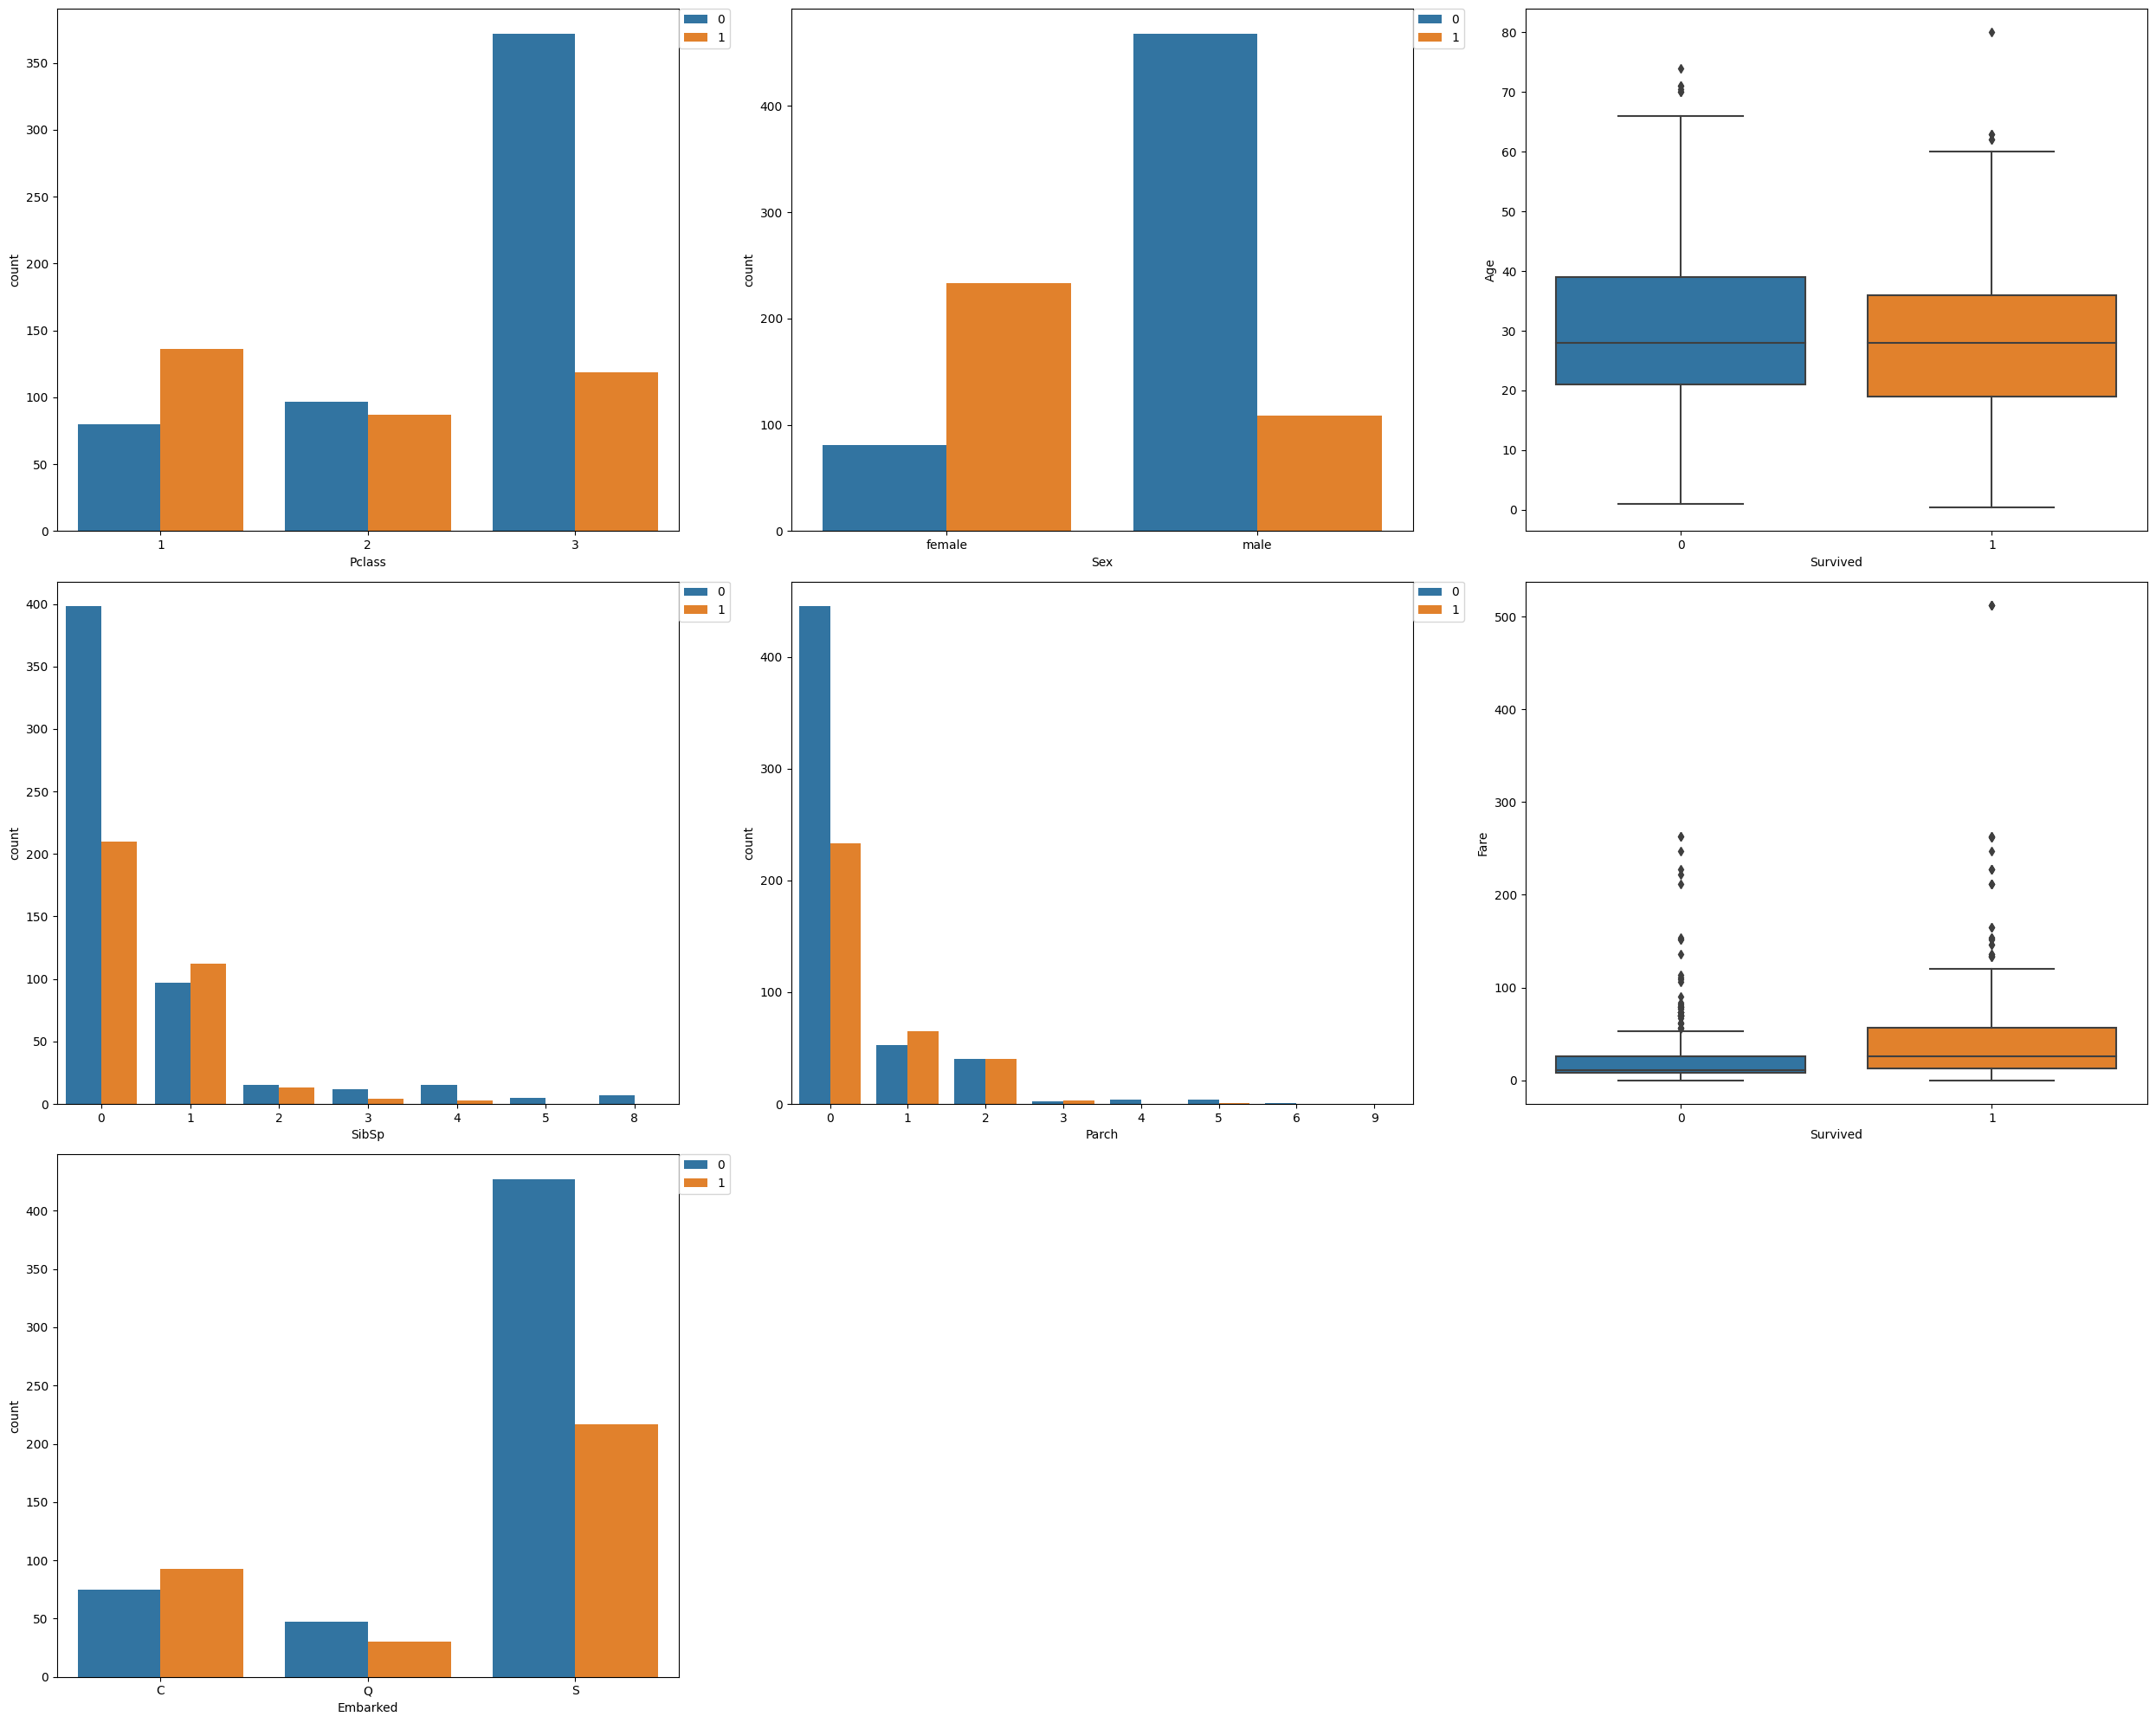

In [295]:
bivariate()

### EDA: Feature Engineering

In [296]:
temp = combined.Name.transform(lambda x:x.split('. ')[0]).transform(lambda x:x.split(', ')[1]) #type: ignore

combined["Titles_New"] = temp

temp.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [297]:
combined.Titles_New.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Titles_New, dtype: int64

In [298]:
combined.Titles_New.replace(to_replace= 'Ms', value='Miss', inplace=True)
combined.Titles_New.replace(to_replace= ['Don', 'Rev', 'Mme', 'Mlle', 'Dona', 'Capt', 'Sir', 'the Countess', 'Jonkheer', 'Major', 'Dr', 'Col', 'Lady'], value='Others', inplace=True)

In [299]:
# Creating Family Column
to_be_num = ['SibSp', 'Parch']
combined[to_be_num] = combined[to_be_num].astype(float) 
combined['Family'] = combined.SibSp + combined.Parch + 1
to_be_num.append('Family')
combined[to_be_num] = combined[to_be_num].astype('Int64') 
combined[to_be_num] = combined[to_be_num].astype('category') 
combined.Family.head()

0    2
1    2
2    1
3    2
4    1
Name: Family, dtype: category
Categories (9, Int64): [1, 2, 3, 4, ..., 6, 7, 8, 11]

In [300]:
combined.Family.value_counts()

1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: Family, dtype: int64

In [301]:
# Creating Family Category.

def total_people(x):
    if x == 1:
        return "Single"
    elif x >= 2 and x < 4:
        return "Small"
    else:
        return "Large"

combined["Family_Cat"] = combined.Family.apply(total_people)

In [302]:
combined.Family = combined.Family.astype('category')

In [303]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1309 non-null   int64   
 1   Survived     891 non-null    category
 2   Pclass       1309 non-null   category
 3   Name         1309 non-null   category
 4   Sex          1309 non-null   category
 5   Age          1046 non-null   float64 
 6   SibSp        1309 non-null   category
 7   Parch        1309 non-null   category
 8   Ticket       1309 non-null   category
 9   Fare         1308 non-null   float64 
 10  Cabin        295 non-null    category
 11  Embarked     1307 non-null   category
 12  Titles_New   1309 non-null   object  
 13  Family       1309 non-null   category
 14  Family_Cat   1309 non-null   object  
dtypes: category(10), float64(2), int64(1), object(2)
memory usage: 157.0+ KB


In [304]:
combined.Family_Cat.value_counts()

Single    790
Small     394
Large     125
Name: Family_Cat, dtype: int64

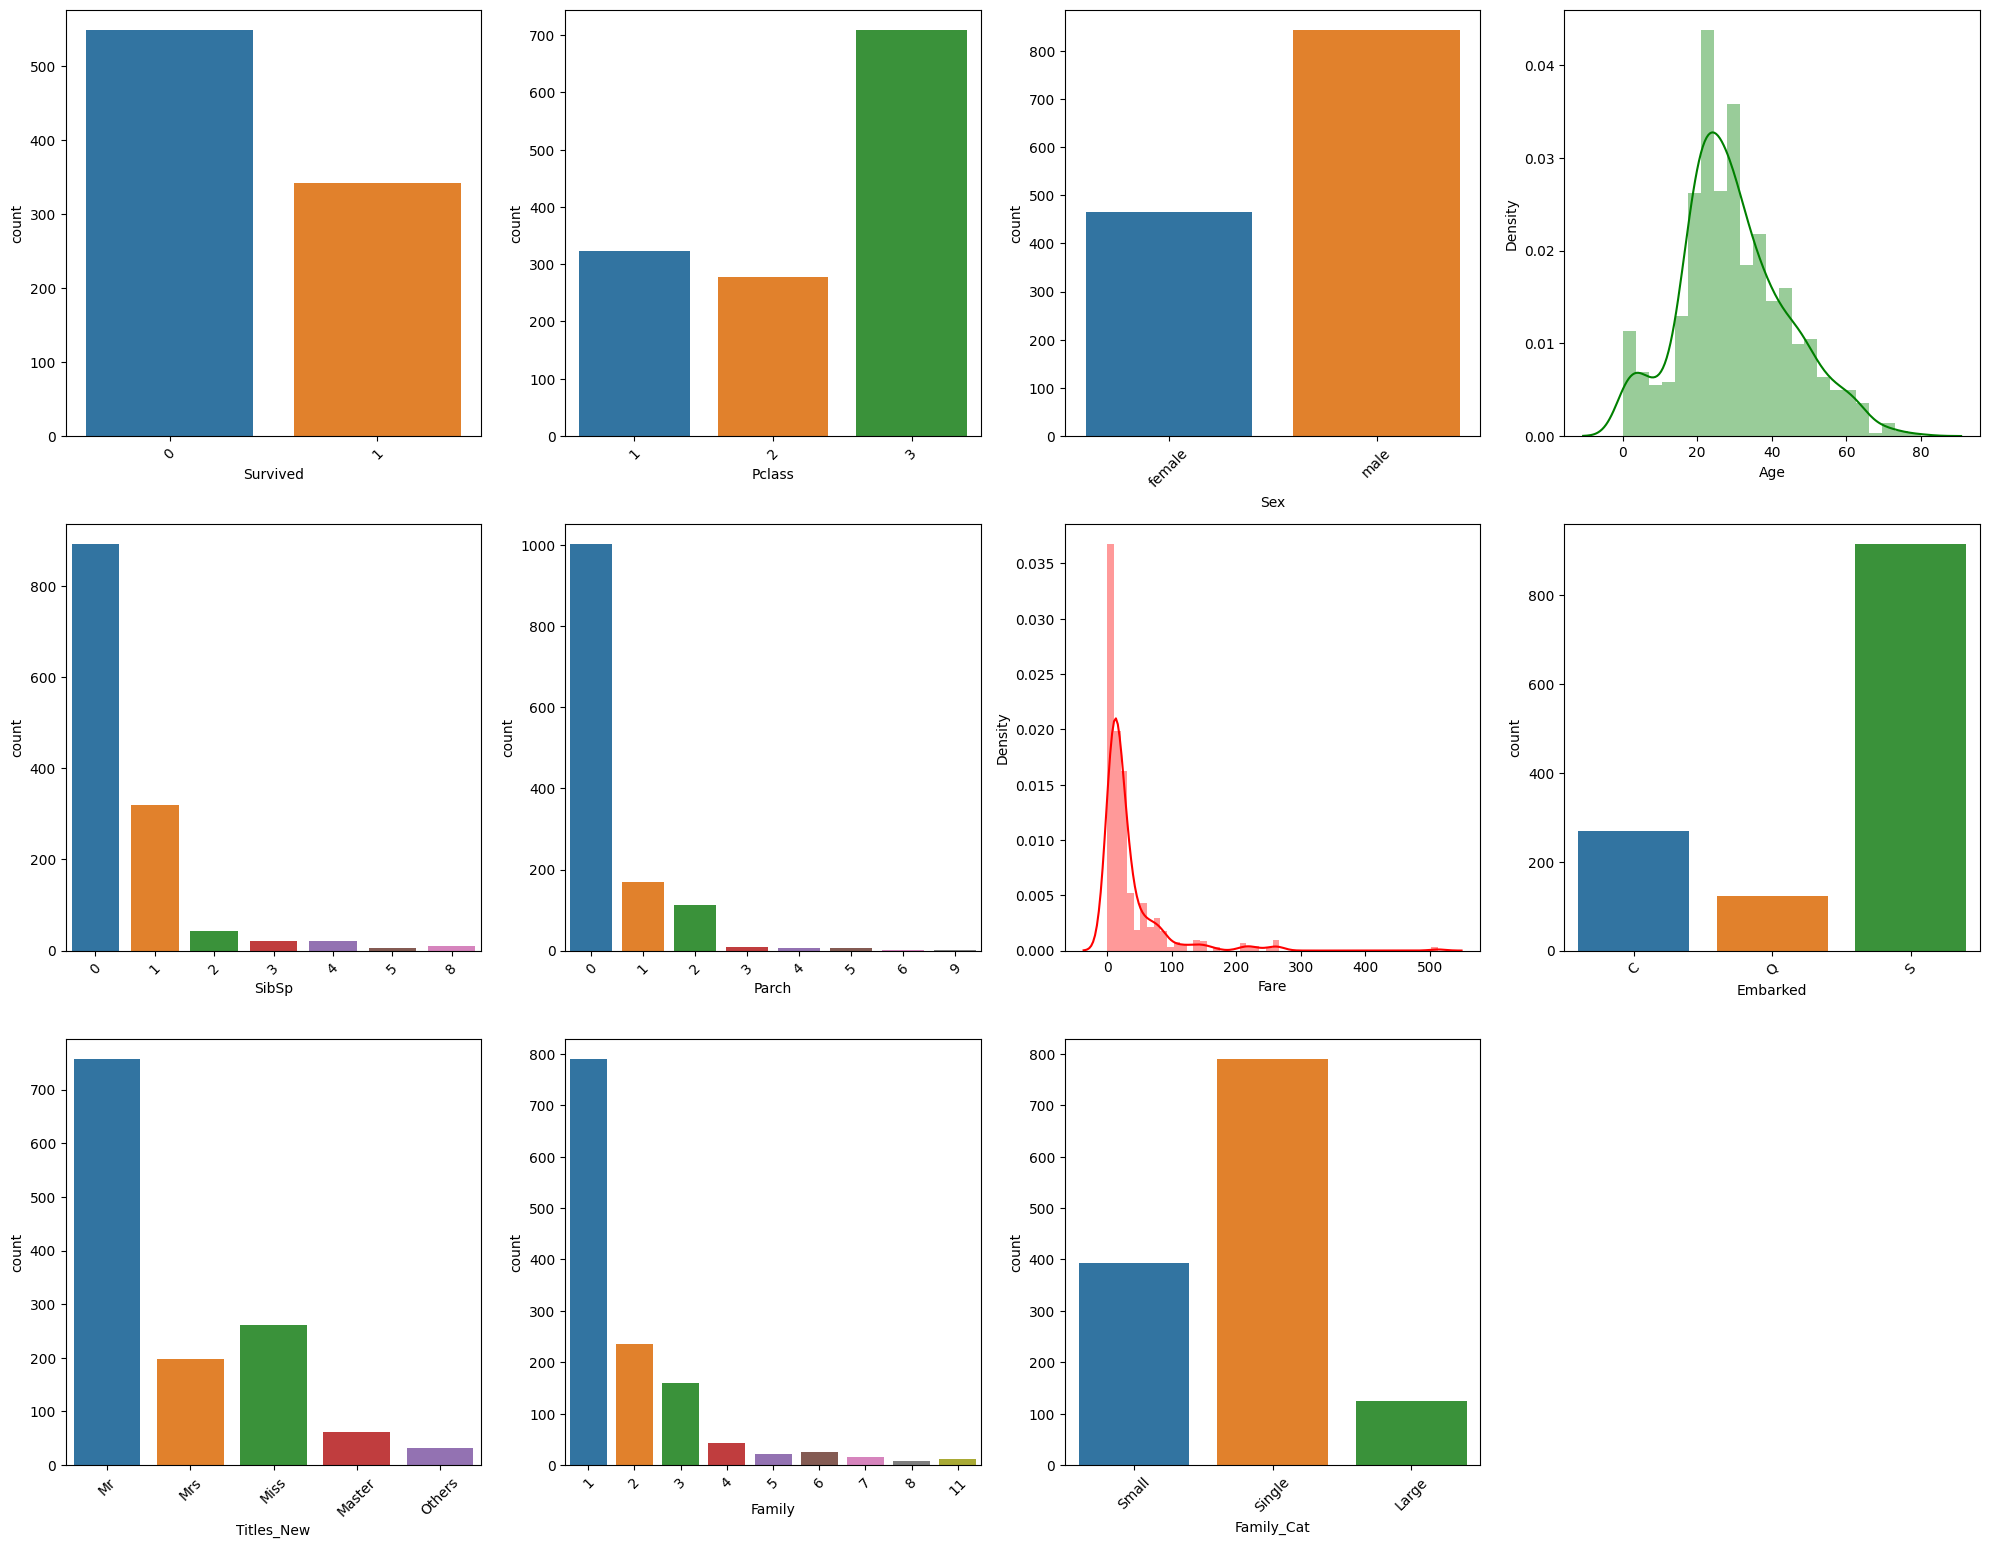

In [305]:
univariate(rows = 4)

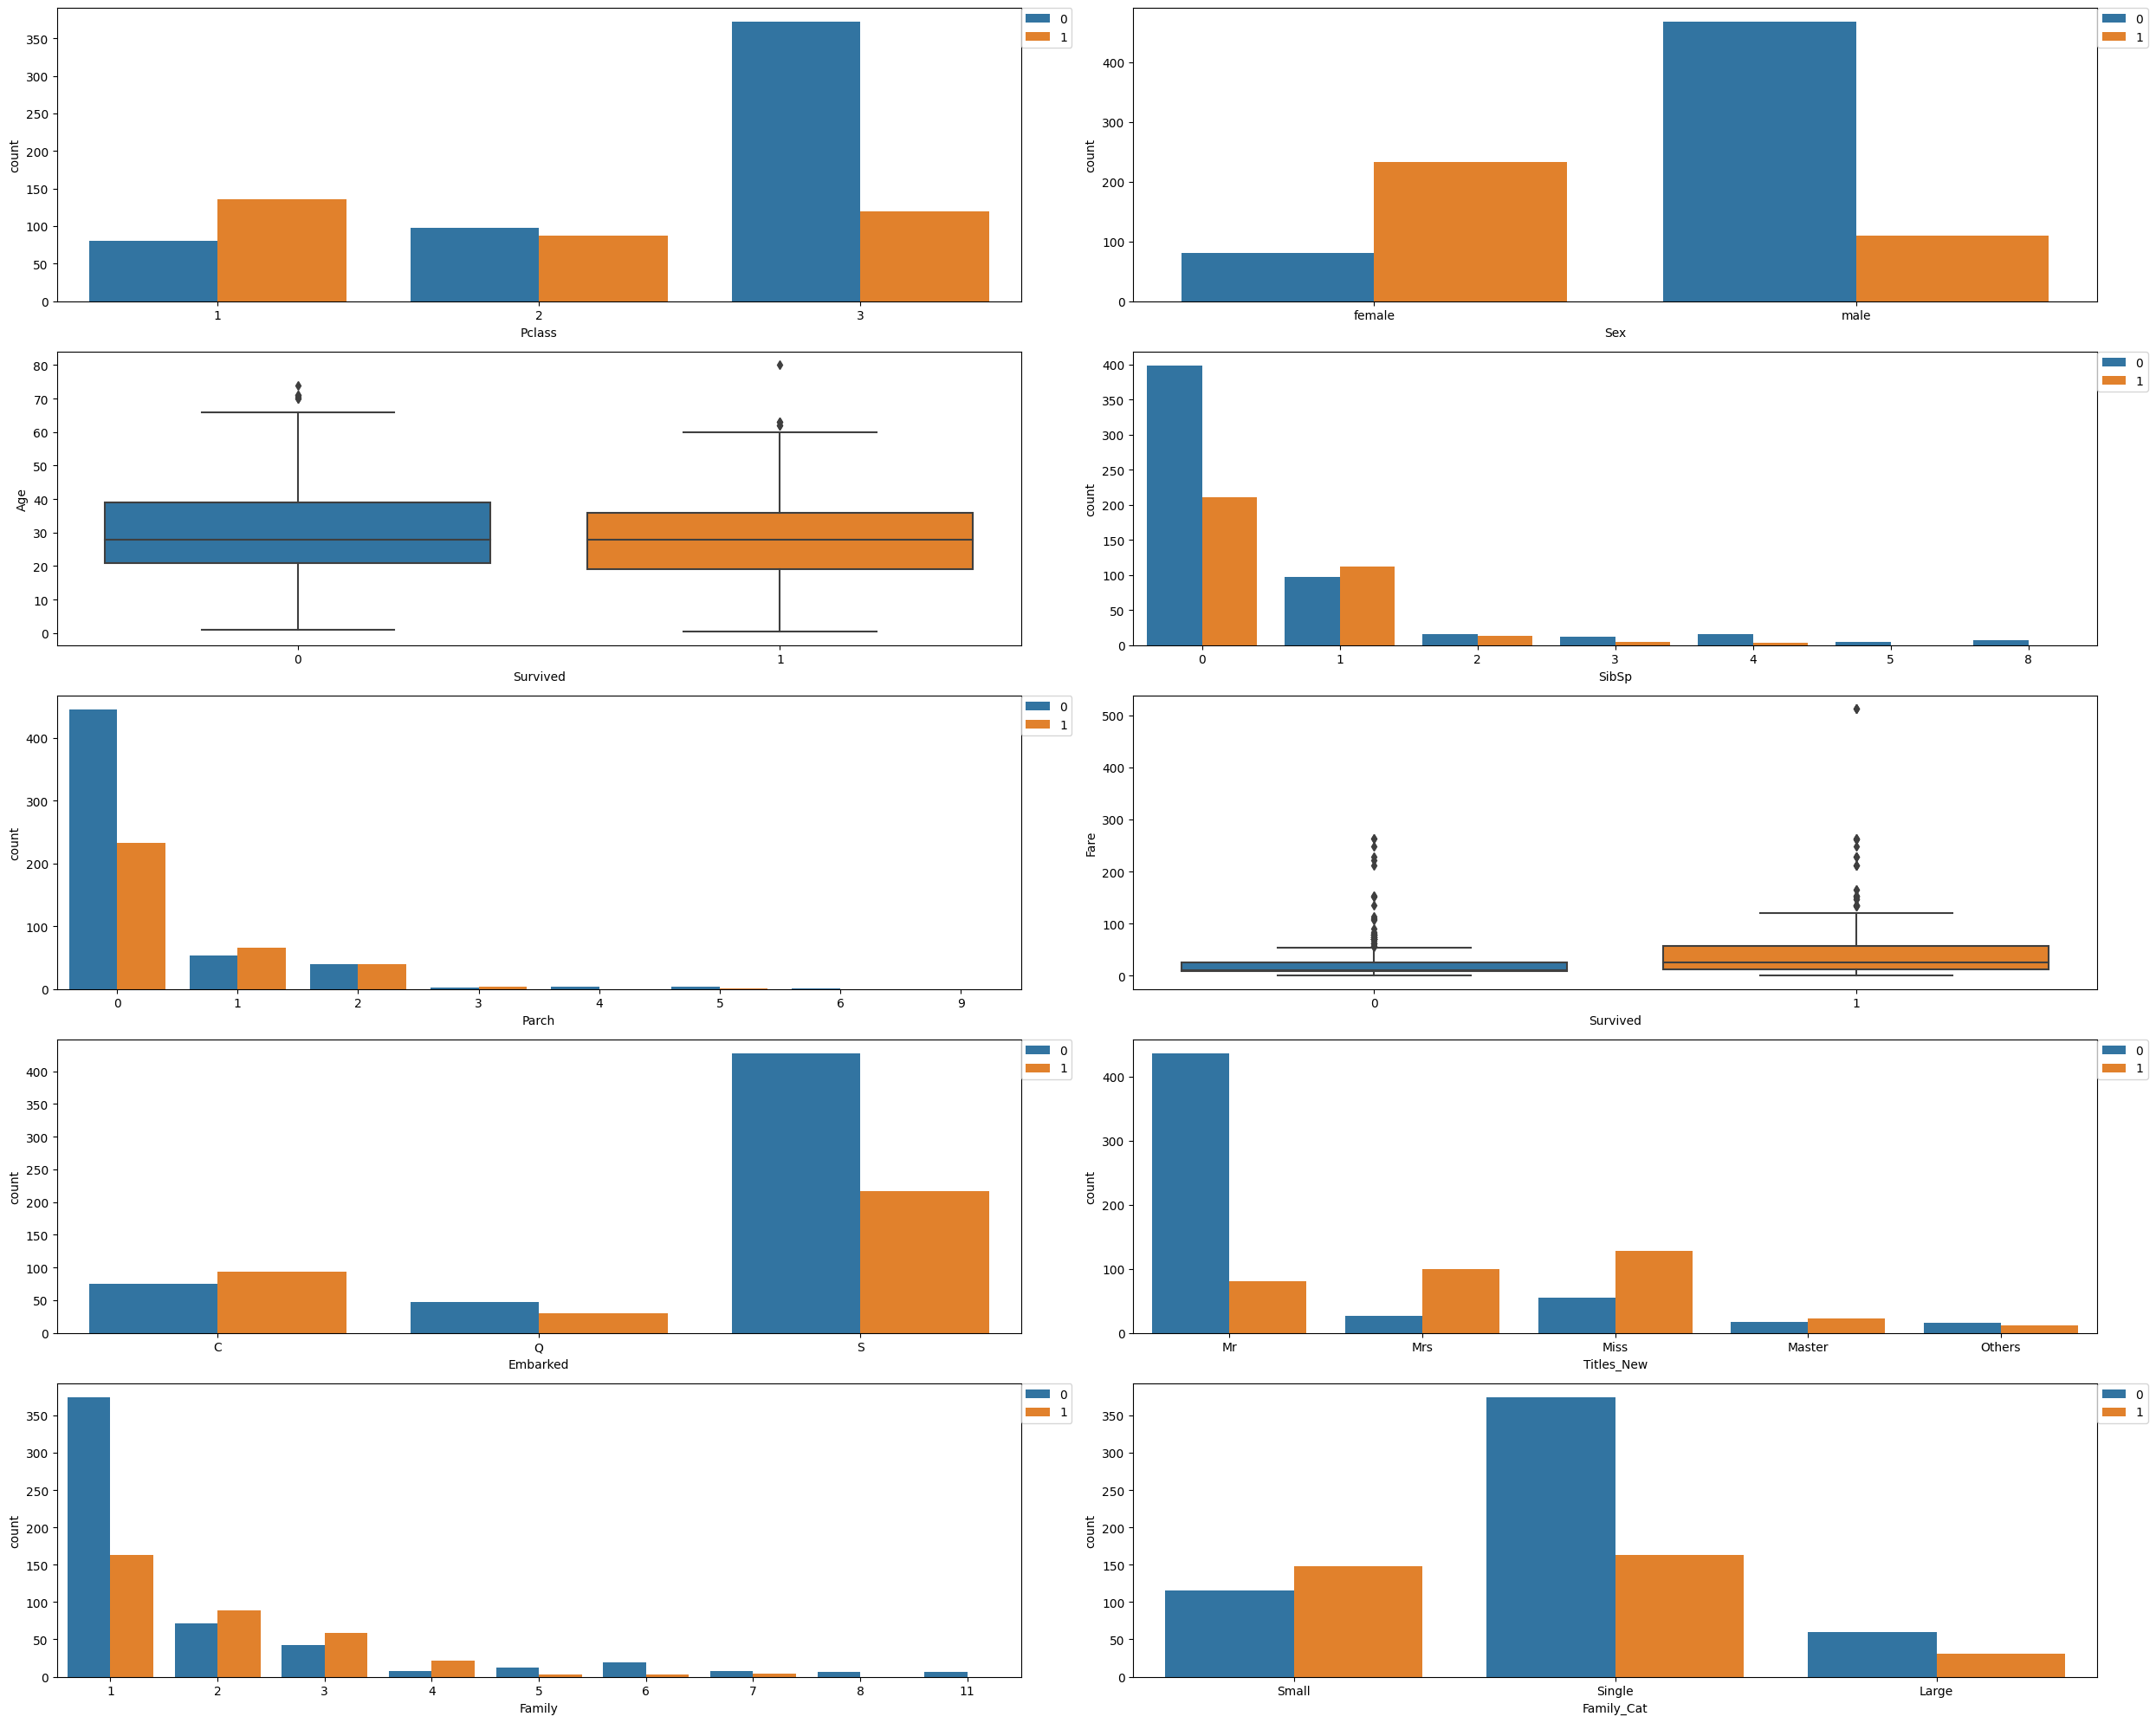

In [306]:
bivariate(rows = 5, cols = 2)

Outlier Treatment

In [307]:
for i in combined.select_dtypes(['int', 'float']):
    if i not in not_plot:
        combined[i] = outlier_red(combined, i)

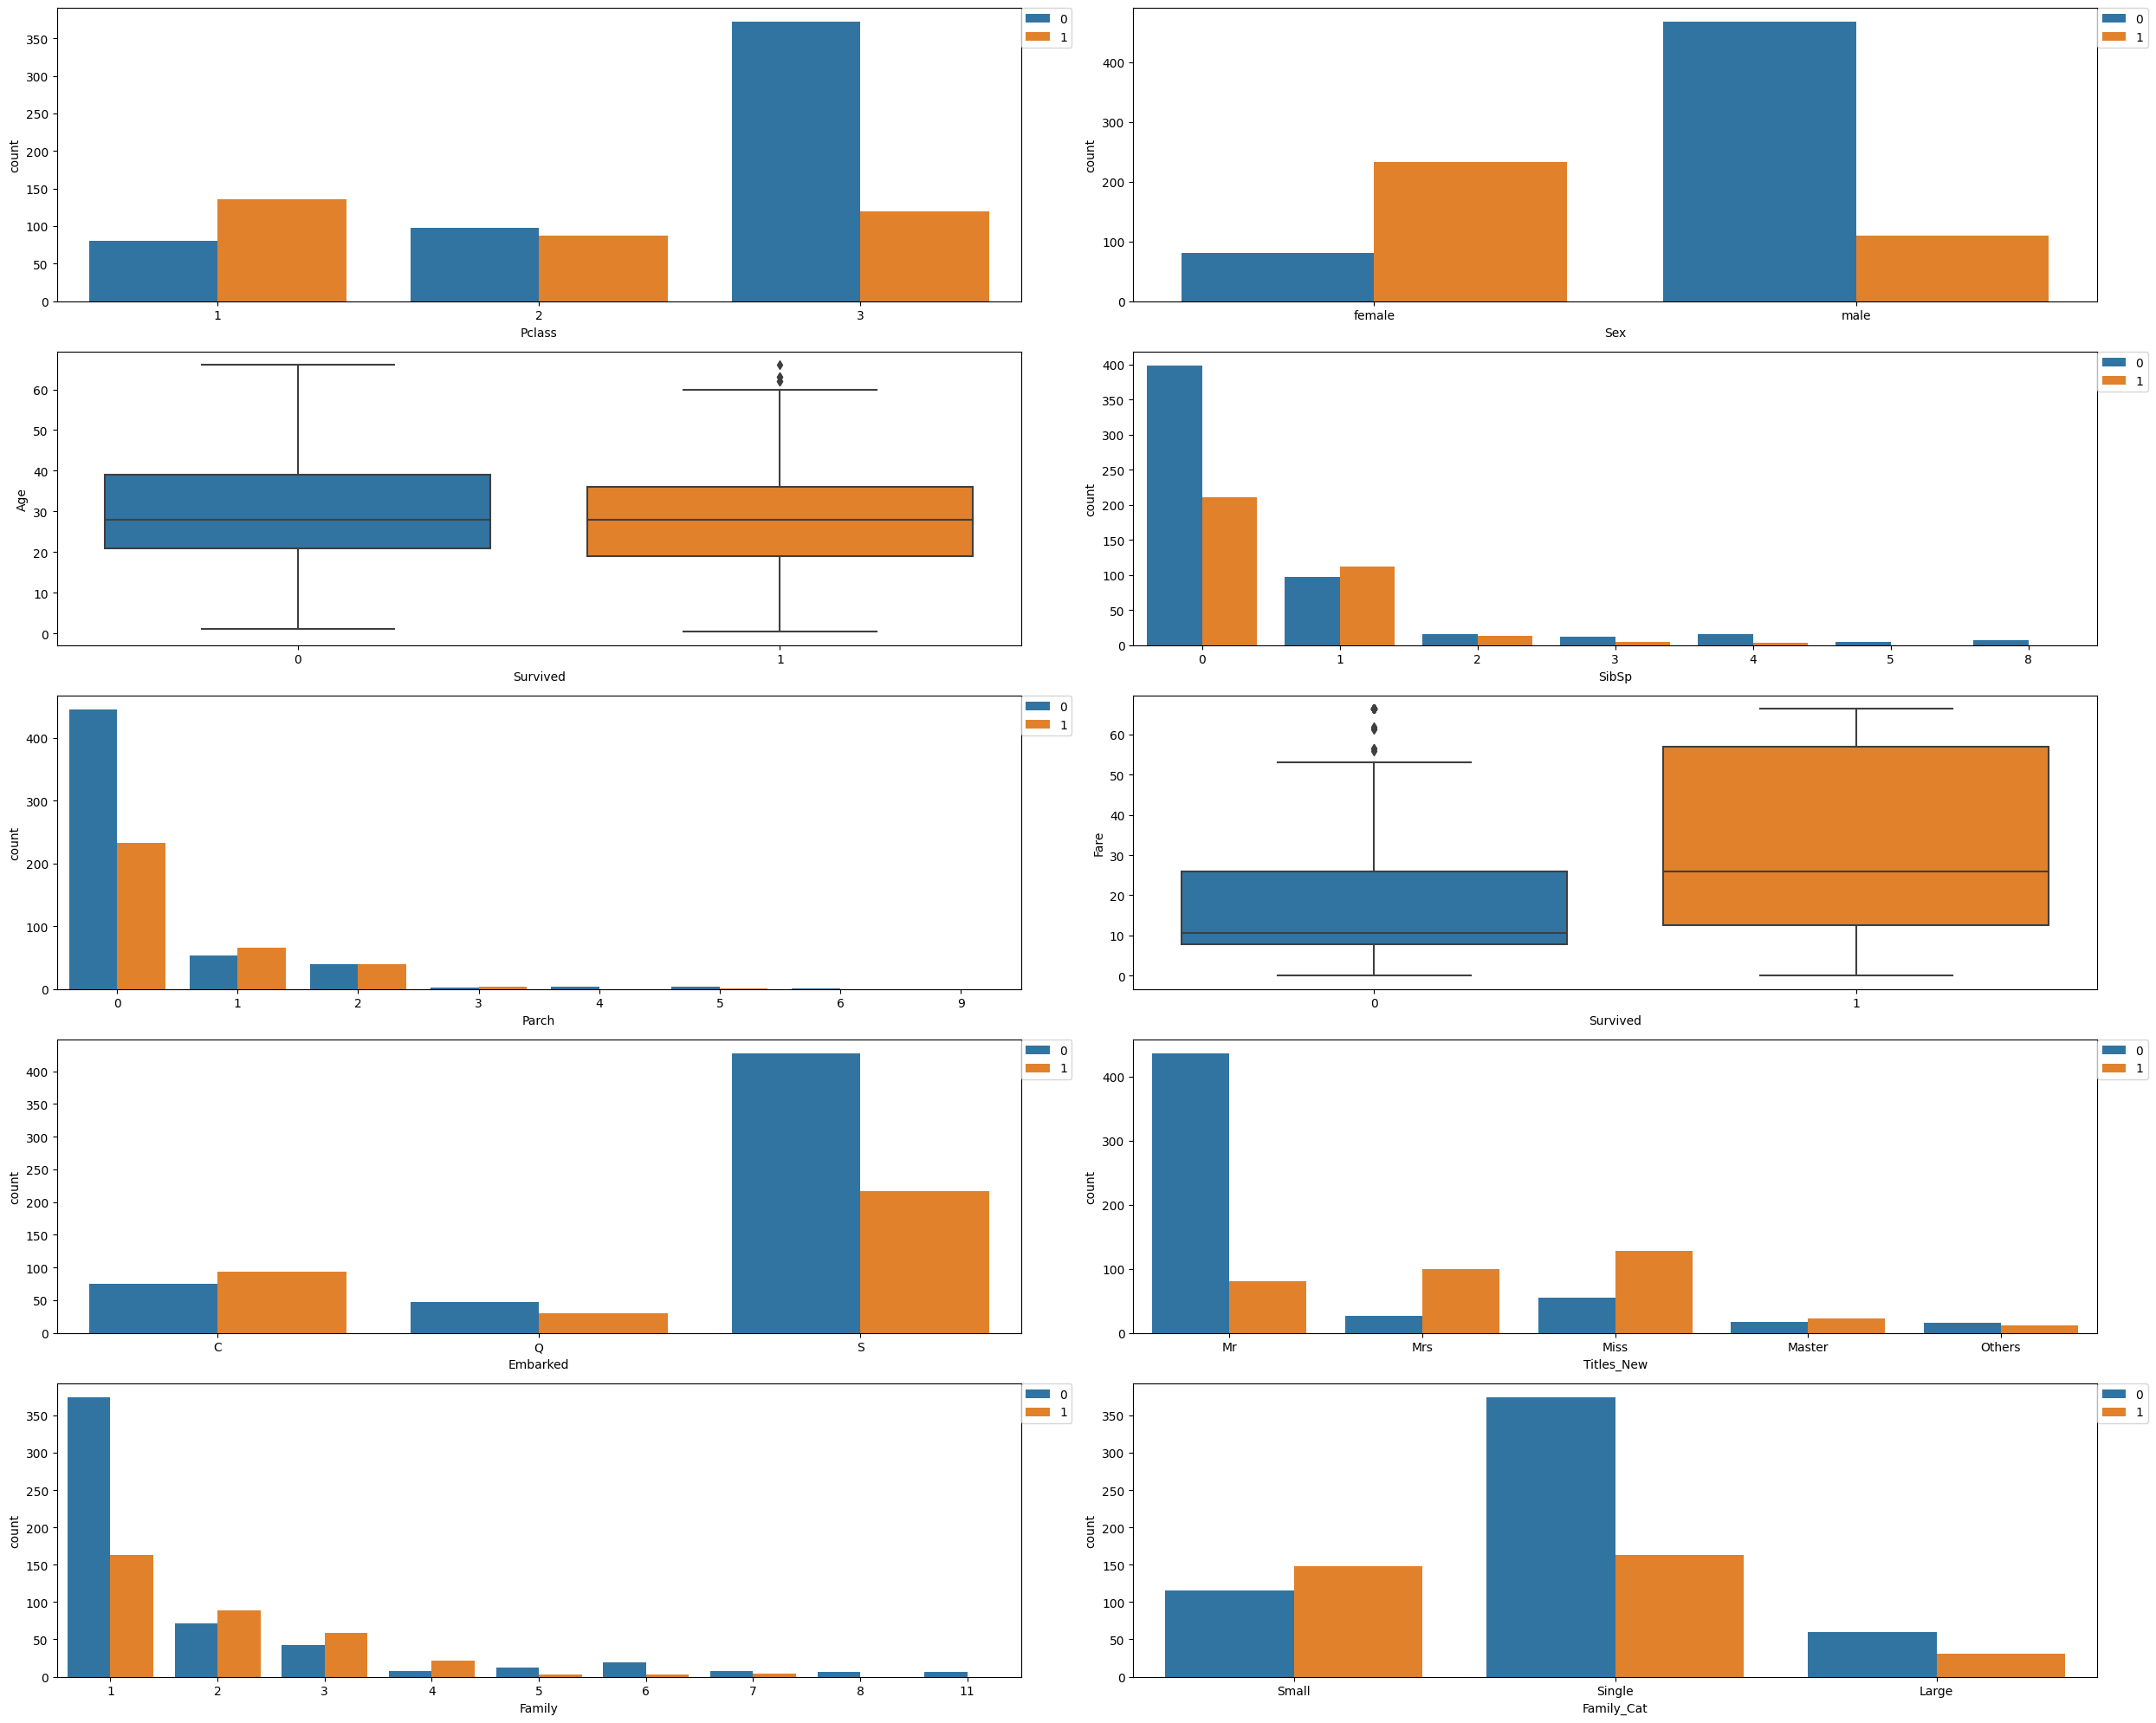

In [308]:
bivariate(rows = 5, cols = 2)

# There is a significant decrease in Outliers in columns 'Age' and 'Fare'.

### Missing Values

In [309]:
combined.isnull().sum()[combined.isnull().sum()>0]

Survived     418
Age          263
Fare           1
Cabin       1014
Embarked       2
dtype: int64

In [310]:
combined.Embarked.value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

Maximum People have boarded the ship from 'Southampton', hence filling both the null values as 'S'.
Just two null values would not create a big difference even if its wrong.

We could check it against Fare or TickteID and see if there is a relation or not. Will try later.

In [311]:
combined.Embarked.fillna('S', inplace=True)

When in any dataset we want to find out the association b/w:

1. Categorical and Numerical -> ANOVA - Analysis of Variance(ftest).

    1.1. Most Imp feature in ANOVA is it can be easily performed on multi categorical data set.

2. Categorical and Categorical -> Chi Square.

3. Numerical and Numerical -> ttest.

In [312]:
anv = ""
for i in combined.columns:
    if i not in not_plot:
        if i != 'Age':
            anv = anv + ' + C(' + i +')' #type: ignore
anv[:]

model = ols('Age ~ {}'.format(anv[3:]), data=combined, test = 'Chisq').fit()
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
C(Survived),1.0,878.685196,878.685196,7.862344,5.239155e-03
C(Pclass),2.0,27079.740655,13539.870328,121.152746,8.336986e-44
C(Sex),1.0,191.652224,191.652224,1.714876,1.909413e-01
C(SibSp),6.0,13397.152714,2232.858786,19.979288,5.041444e-21
C(Parch),7.0,8363.594388,1194.799198,10.690885,1.356006e-12
C(Fare),233.0,34583.070239,148.425194,1.328087,4.759593e-03
C(Embarked),2.0,169.606304,84.803152,0.758806,4.687510e-01
C(Titles_New),4.0,10862.216921,2715.554230,24.298375,1.983307e-18
C(Family),8.0,1174.130501,146.766313,1.313243,2.341898e-01
C(Family_Cat),2.0,536.546005,268.273003,2.400467,9.169546e-02


For Missing value of Age:

1. SibSP and Parch has a big impact, hence using the combination of both(Family_Cat = SibSp + Parch), although Family_Cat's and Family's p-value 
is more than 0.05. Still giving it a shot.

2. Pclass has an impact.

3. Gender has no impact.

4. Title has an impact.

In [313]:
combined.groupby(['Pclass', 'Family_Cat', 'Titles_New'])['Age'].describe()

count       mean        std    min      25%  \
Pclass Family_Cat Titles_New                                                
1      Large      Master        3.0   8.306667   6.474730   0.92   5.9600   
                  Miss          7.0  18.571429   8.560708   2.00  16.0000   
                  Mr            5.0  42.000000  19.710403  19.00  30.0000   
                  Mrs           5.0  39.200000  14.754660  25.00  27.0000   
       Single     Miss         35.0  33.657143   9.551541  16.00  29.5000   
                  Mr           72.0  42.145833  12.383098  17.00  32.1250   
                  Mrs           7.0  53.857143   6.309479  44.00  50.5000   
                  Others       14.0  40.642857  12.263813  24.00  32.2500   
       Small      Master        2.0   5.000000   1.414214   4.00   4.5000   
                  Miss         17.0  28.352941  13.541331  15.00  19.0000   
                  Mr           55.0  40.036364  13.453574  17.00  27.5000   
                  Mrs          55.0  42.036364  13.867045  17.00  35.0000   
                  Others        7.0  51.000000   7.164728  44.00  47.5000   
2      Large      Master        1.0   1.000000        NaN   1.00   1.0000   
                  Miss          9.0  10.435556   9.796294   0.92   3.0000   
                  Mr            4.0  33.250000  11.954776  23.00  24.5000   
                  Mrs           8.0  33.875000  11.716137  22.00  24.0000   
       Single     Miss         24.0  28.687500   9.773314  12.00  20.7500   
                  Mr           96.0  31.890625  12.407172  14.00  23.0000   
                  Mrs          15.0  35.066667  10.944448  22.00  28.5000   
                  Others        7.0  42.142857  13.145704  23.00  34.0000   
       Small      Master       10.0   2.933000   2.804794   0.67   0.8725   
                  Miss         16.0  15.000000   8.540101   2.00   7.7500   
                  Mr           37.0  33.324324  10.192056  19.00  26.0000   
                  Mrs          31.0  32.677419  10.228676  14.00  25.5000   
                  Others        3.0  37.333333  14.468356  28.00  29.0000   
3      Large      Master       22.0   6.068182   4.065814   1.00   2.2500   
                  Miss         19.0   9.087895   9.107223   0.17   2.5000   
                  Mr           12.0  26.916667  11.007917  14.00  16.0000   
                  Mrs          11.0  37.454545   7.132512  24.00  33.0000   
       Single     Master        0.0        NaN        NaN    NaN      NaN   
                  Miss         59.0  22.830508   6.669288   5.00  18.0000   
                  Mr          256.0  28.437500   9.810259  11.00  21.0000   
                  Mrs           5.0  39.000000  16.718253  18.00  31.0000   
       Small      Master       15.0   6.122000   4.420758   0.33   1.9150   
                  Miss         25.0  10.740000   8.742997   1.00   2.0000   
                  Mr           44.0  27.727273   9.132395  15.00  20.0000   
                  Mrs          33.0  29.606061   9.024063  15.00  24.0000   

                               50%     75%   max  
Pclass Family_Cat Titles_New                      
1      Large      Master      11.0  12.000  13.0  
                  Miss        21.0  23.500  28.0  
                  Mr          36.0  61.000  64.0  
                  Mrs         36.0  48.000  60.0  
       Single     Miss        33.0  38.000  58.0  
                  Mr          42.0  49.000  66.0  
                  Mrs         55.0  57.500  62.0  
                  Others      39.5  51.250  60.0  
       Small      Master       5.0   5.500   6.0  
                  Miss        22.0  33.000  63.0  
                  Mr          39.0  50.000  66.0  
                  Mrs         45.0  52.000  66.0  
                  Others      49.0  51.500  66.0  
2      Large      Master       1.0   1.000   1.0  
                  Miss         5.0  20.000  24.0  
                  Mr          30.5  39.250  49.0  
                  Mrs         3

In [314]:
def fill_na_Age(df):
    temp_desc = pd.DataFrame(combined.groupby(['Pclass', 'Family_Cat', 'Titles_New'])['Age'].describe())
    for i in df.Pclass.unique():
        for j in df.Family_Cat.unique():   
            for k in df.Titles_New.unique():
                try:
                    if (type(temp_desc.loc[i, j, k].loc['50%']) == np.float64) & (pd.isna(temp_desc.loc[i, j, k].loc['50%']) == False): #type: ignore
                        df.loc[(df.Pclass == i) & (df.Family_Cat == j) & (df.Titles_New == k) & (df.Age.isna()), 'Age'] = temp_desc.loc[i, j, k].loc['50%'] #type: ignore
                except:
                    pass
    df.Age.fillna(combined[combined.Titles_New == 'Master']['Age'].mean(), inplace=True)
    return df

In [315]:
combined = fill_na_Age(combined)

In fare, just 1 Null value would not impact much. Filling it with the total mean.

In [316]:
combined.Fare.fillna(combined.Fare.mean(), inplace=True)

In [317]:
combined.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], inplace=True, axis = 1)

In [318]:
combined.isnull().sum()[combined.isnull().sum()>0]

Survived    418
dtype: int64

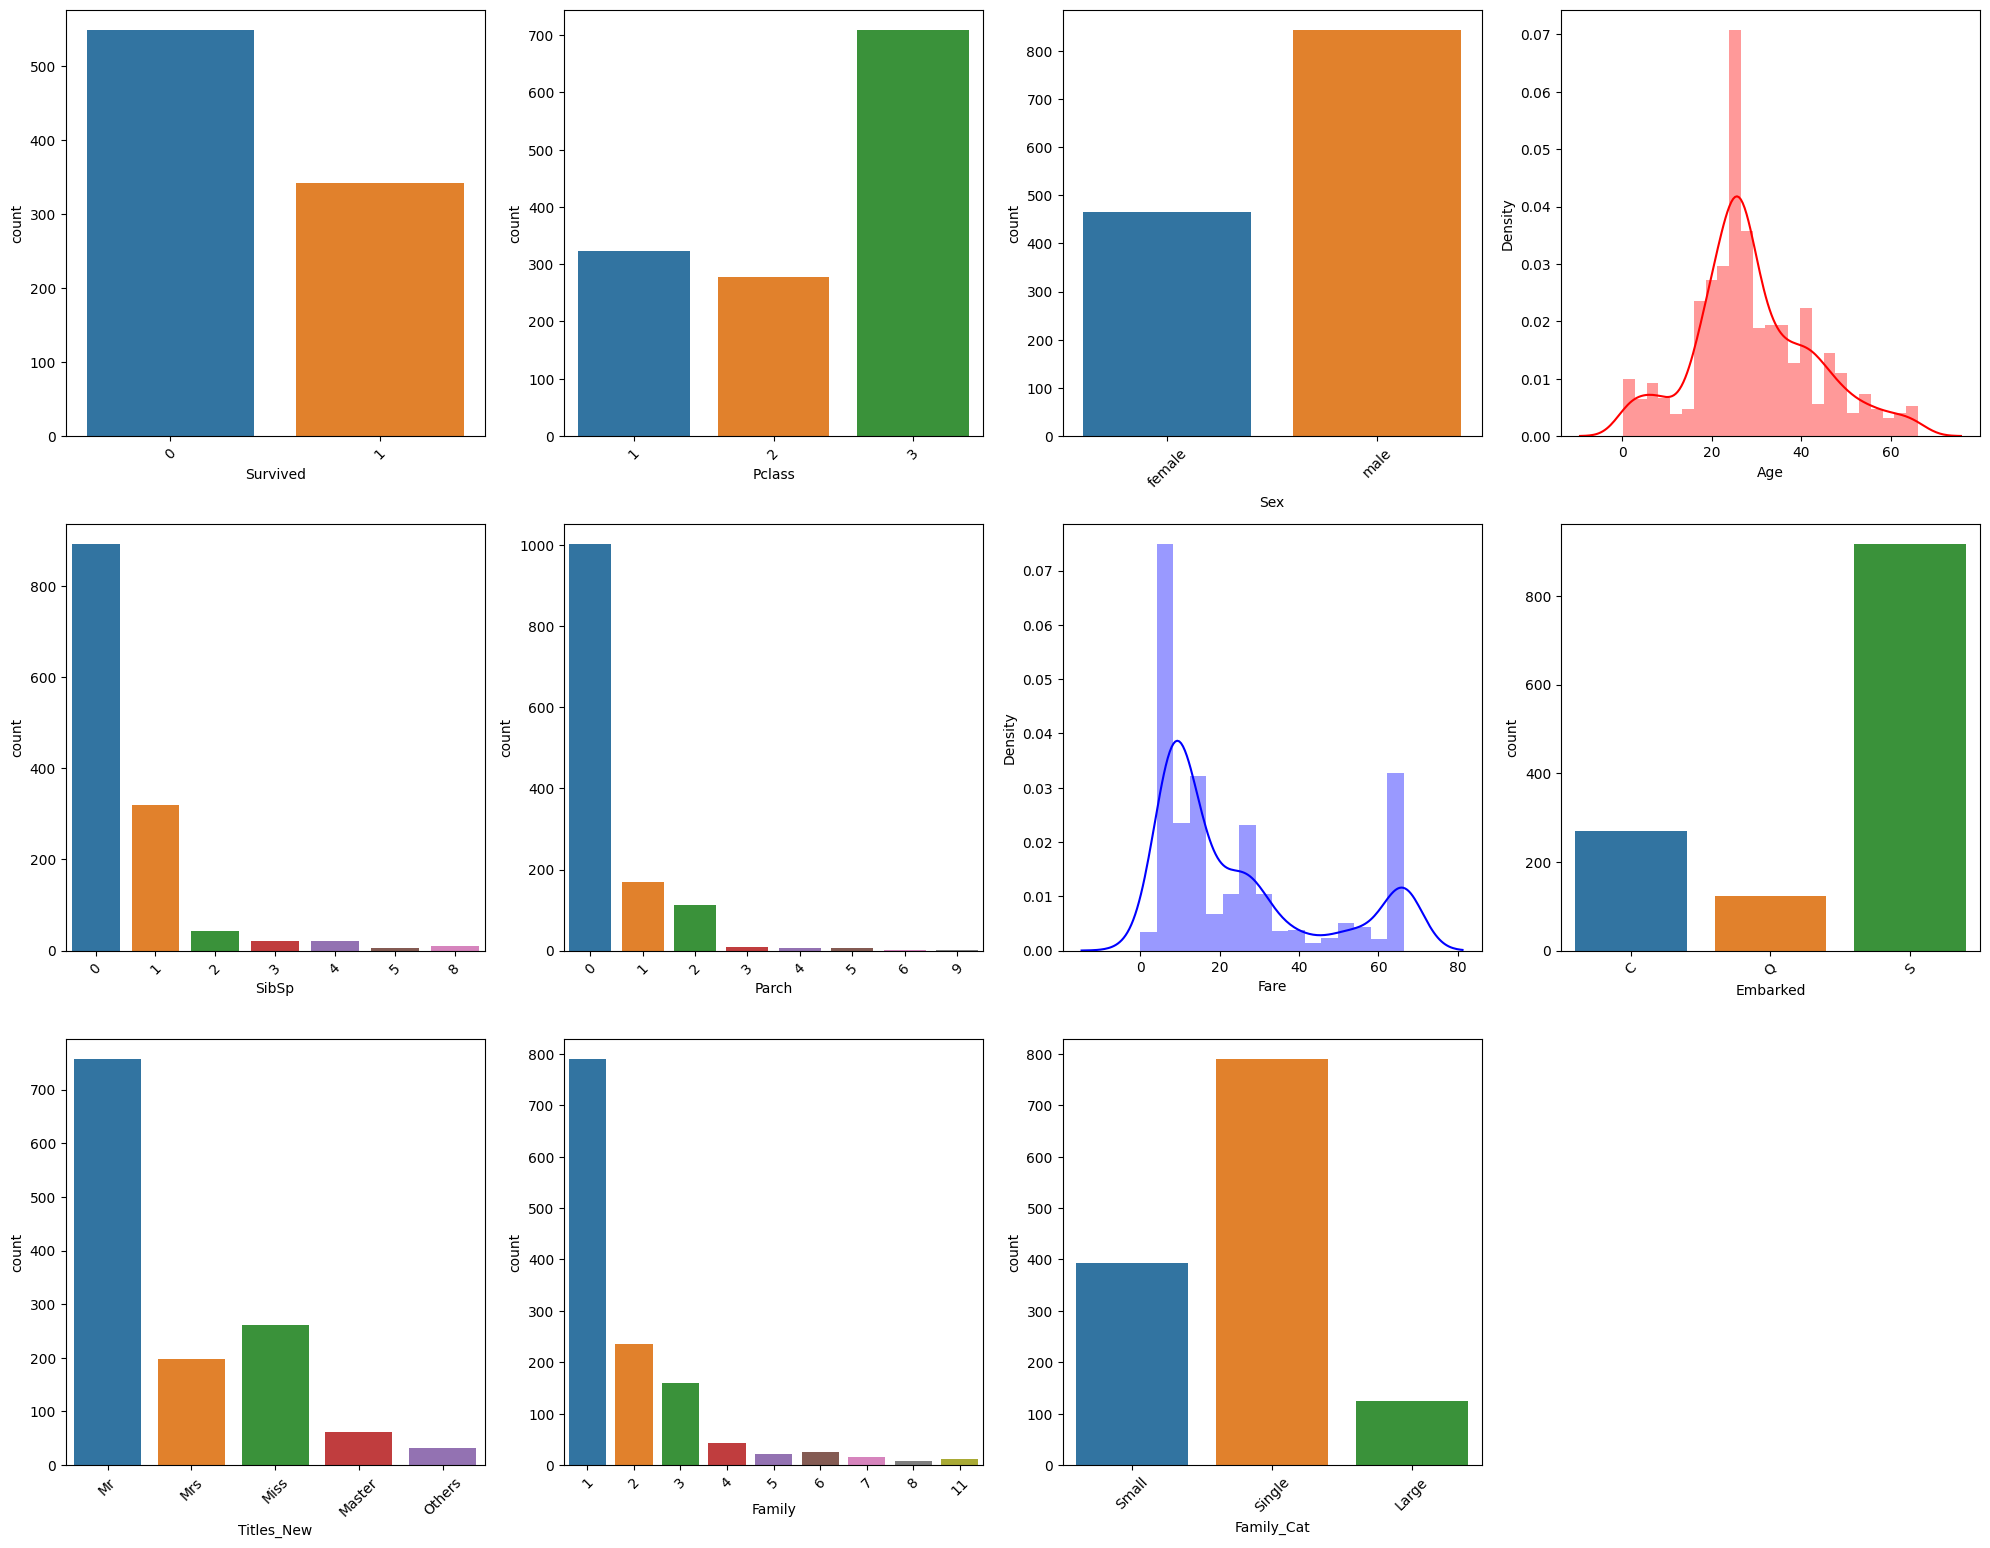

In [319]:
univariate()

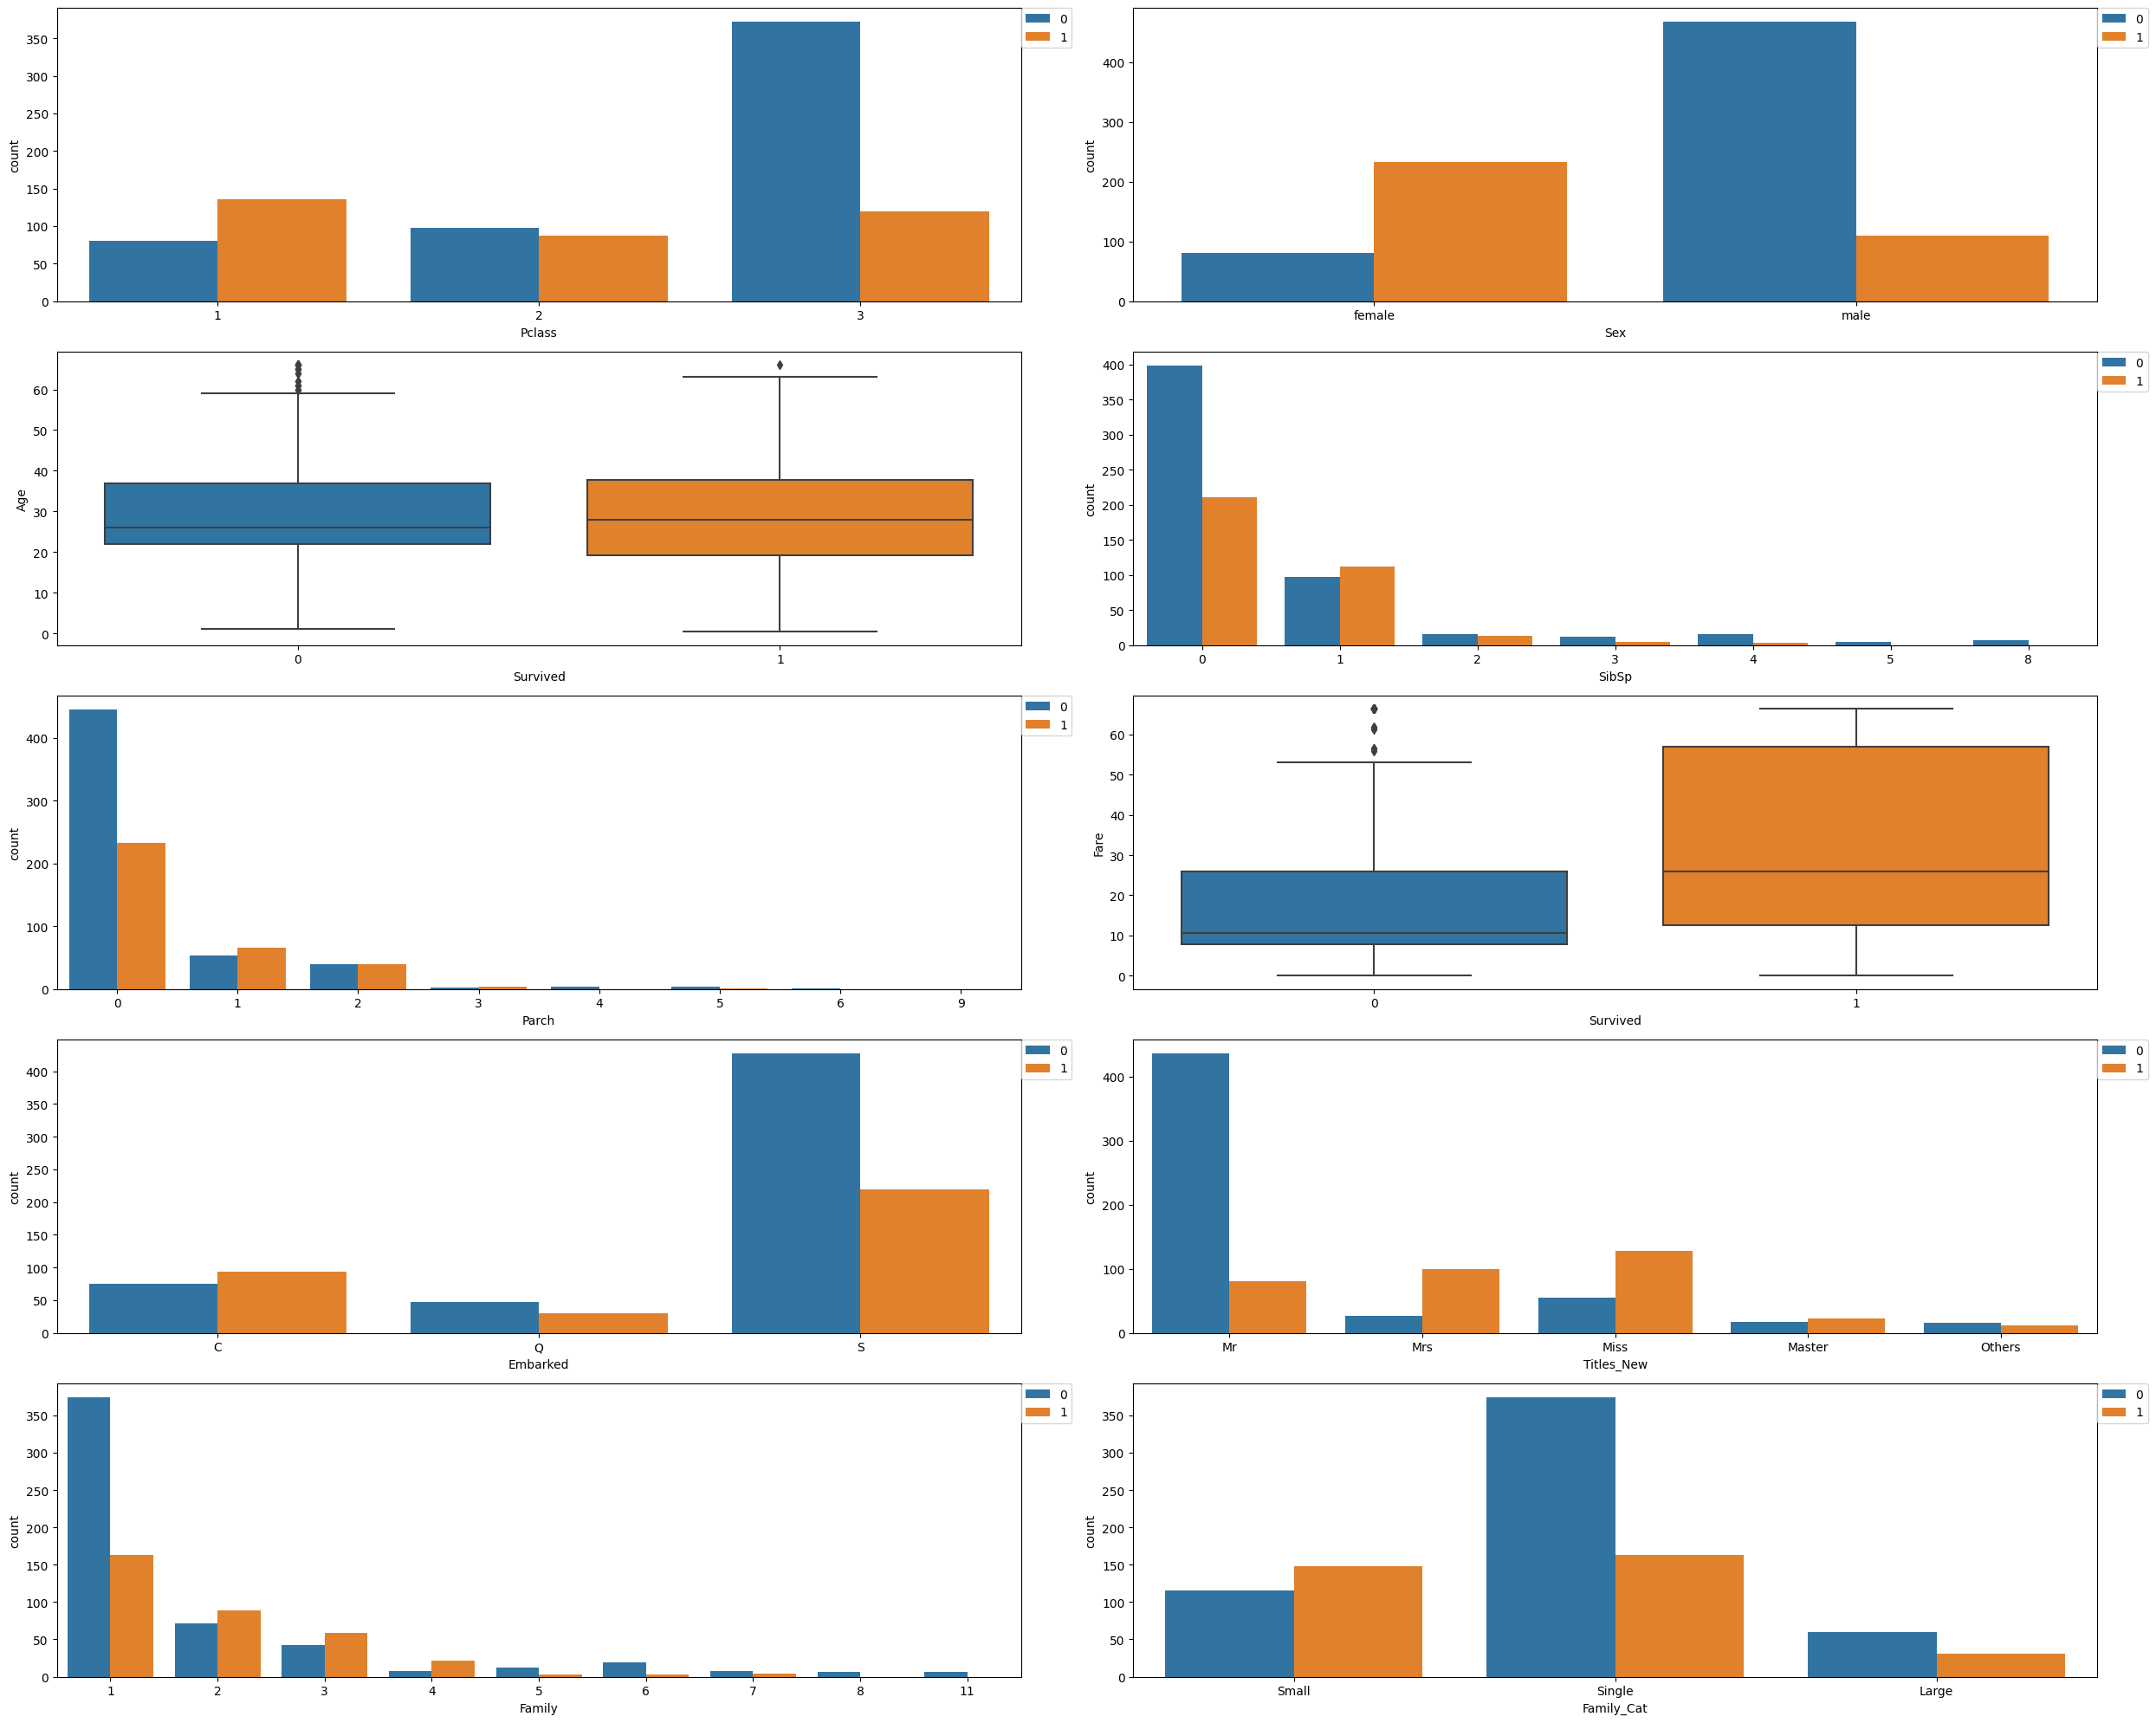

In [320]:
bivariate(rows = 5, cols = 2)

### Encoding

In [321]:
target = combined[target_var]
target = pd.DataFrame(target, columns=[target_var])

lb_x = combined.loc[:, combined.columns != target_var].apply(LabelEncoder().fit_transform) #type: ignore

combined_lb = pd.concat([lb_x, target], axis=1)
combined_lb.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Titles_New,Family,Family_Cat,Survived
0,2,1,34,1,0,20,2,2,1,2,0
1,0,0,60,1,0,234,0,3,1,2,1
2,2,0,41,0,0,50,2,1,0,1,1
3,0,0,56,1,0,218,2,3,1,2,1
4,2,1,56,0,0,52,2,2,0,1,0


In [322]:
def encod(df, lb, gd):
    
    x = df.loc[:, df.columns != target_var] # type: ignore
    y = df[target_var]

    x[lb] = x[lb].apply(LabelEncoder().fit_transform) #type: ignore

    x = pd.get_dummies(data = x, columns = gd, drop_first=True)

    return pd.concat([x, y], axis=1) #type: ignore

In [323]:
combined_en =  encod(df = combined, lb = ["Titles_New"], gd = ["Sex", "Embarked", "Family_Cat"])
combined_en.head()

,Pclass,Age,SibSp,Parch,Fare,Titles_New,Family,Sex_male,Embarked_Q,Embarked_S,Family_Cat_Single,Family_Cat_Small,Survived
0,3,22.0,1,0,7.2500,2,2,1,0,1,0,1,0
1,1,38.0,1,0,66.3438,3,2,0,0,0,0,1,1
2,3,26.0,0,0,7.9250,1,1,0,0,1,1,0,1
3,1,35.0,1,0,53.1000,3,2,0,0,1,0,1,1
4,3,35.0,0,0,8.0500,2,1,1,0,1,1,0,0


### Model Building

#### 1. Logistic Regression

In [324]:
# Implementing SMOTE

def smote(x, y):
    oversample = SMOTE(random_state = 2, sampling_strategy='minority')

    x = x.values
    y = y.values

    x, y = oversample.fit_resample(x, y) #type: ignore
    return x, y

In [325]:
# Splitting combined into x_train, x_test, y_train, y_test

def split_data(df, y = target_var):

    x_train = df[df[y].notnull()]
    x_train.drop(y, inplace=True, axis=1)

    x_test = df[df[y].isnull()]
    x_test.drop(y, inplace=True, axis=1)
    y_train = df[df[y].notnull()][y]

    y_test = df[df[y].isna()][y]

    return x_train, x_test, y_train, y_test

In [326]:
def create_cm(model, tup):
    x, xv, y, yv = tup[0], tup[1], tup[2], tup[3]

    model.fit(x, y)
    yp = model.predict(xv)
    
    cm = confusion_matrix(yv, yp)
    cm_df = pd.DataFrame(cm, columns=['Pred: 0', 'Pred: 1'], index = ['Obs: 0', 'Obs: 1'])

    sns.heatmap(cm_df, annot=True, fmt='d')
    plt.show()
    
    print(classification_report(yv, yp))

In [327]:
# General Random Search Model that could be used by all Classification Models. 

# General Grid Search Model that could be used by all Classification Models. 

def rand_search(model, params, df = combined_en, cm = 'yes', subm = 'yes'):
    x, x_test, y, y_test = split_data(df)
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=123)

    x_train, y_train = smote(x_train, y_train)
    print(Counter(y_train))
    
    x_train = sc.fit_transform(x_train)
    x_val = sc.transform(x_val)

    grid_mod = RandomizedSearchCV(model, param_distributions=params, scoring = ['accuracy'], cv = 10, n_jobs=10, refit='accuracy') #type: ignore
    grid_mod.fit(x_train, y_train)

    if subm == 'yes':
        y_pred = grid_mod.predict(x_test)
        sub(str(model)[:4], y_pred)

    if cm == 'yes':
        create_cm(grid_mod.best_estimator_, (x_train, x_val, y_train, y_val))

    return grid_mod.best_estimator_, grid_mod.best_score_

In [328]:
x_train, x_test, y_train, y_test = split_data(combined_lb) 

model = sm.Logit(y_train, ac(x_train))
res = model.fit(method='bfgs')

print(res.summary())

         Current function value: 0.432709
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      881
Method:                           MLE   Df Model:                            9
Date:                Sat, 28 Jan 2023   Pseudo R-squ.:                  0.3502
Time:                        19:54:28   Log-Likelihood:                -385.54
converged:                      False   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 6.518e-84
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.3005      0.644      5.127      0.000       2.039       4.5

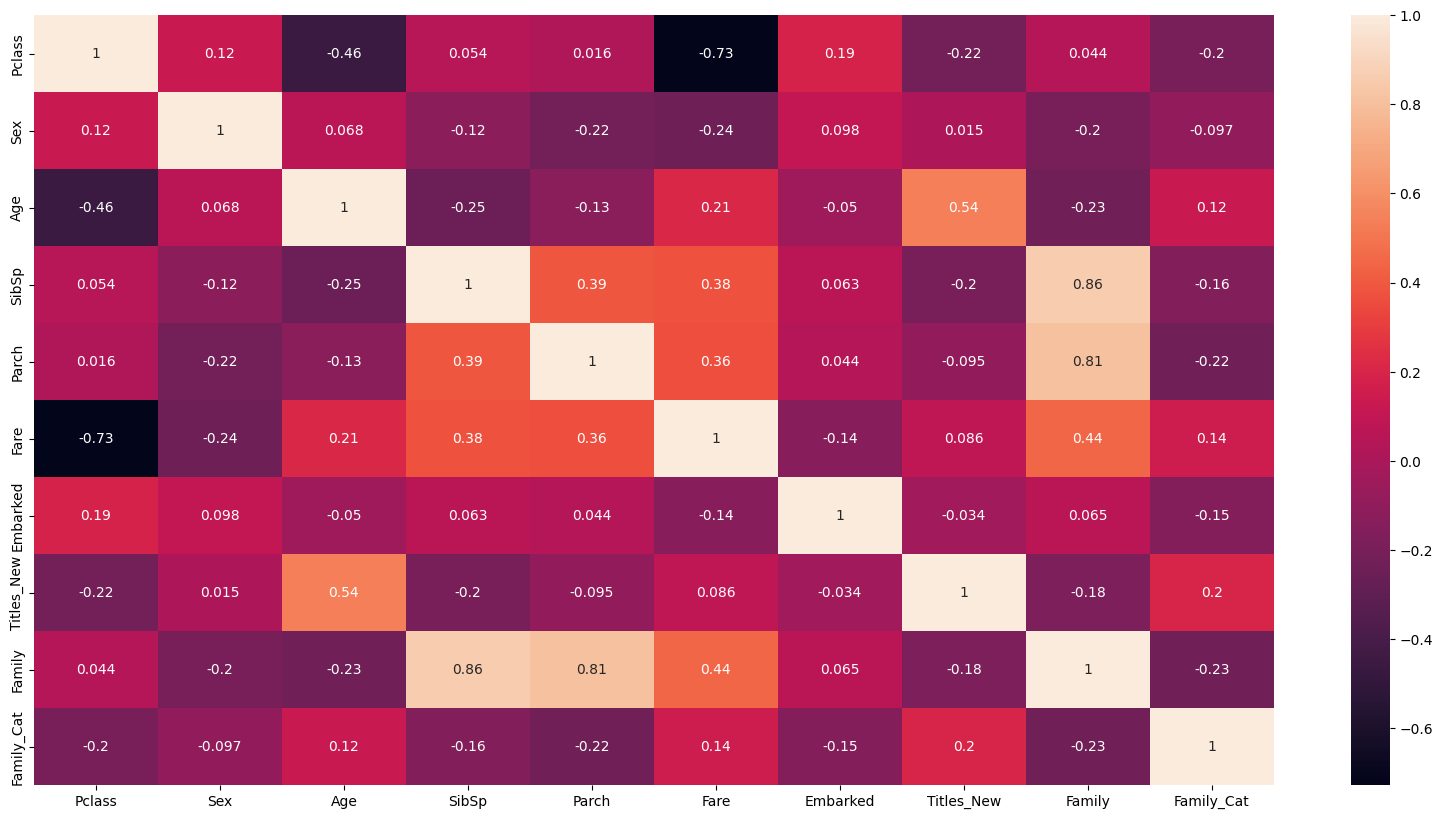

In [329]:
# Checking Multicollinearity - Values greater than 0.40 indicate Multicollinearity.

check_multicol(combined_lb)

In [330]:
# Removing cols with p-value more than 0.05

def back_feat_elem(df = combined_lb):
    x_train, x_test, y_train, y_test = split_data(df) 

    col = x_train.columns

    while len(col) > 0:
        model = sm.Logit(y_train, ac(x_train[col]))
        result = model.fit(disp= 0, method='bfgs')
        largest_pvalue = round(result.pvalues, 3).nlargest(1)
        if largest_pvalue[0] < (0.05):
            return result
            break
        else:
            col = col.drop(largest_pvalue.index)

In [331]:
back_res = back_feat_elem()
back_res.summary() #type: ignore

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      885
Method:                           MLE   Df Model:                            5
Date:                Sat, 28 Jan 2023   Pseudo R-squ.:                  0.3410
Time:                        19:54:28   Log-Likelihood:                -391.02
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 3.012e-85
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7637      0.484      7.774      0.000       2.815       4.713
Pclass        -1.2374      0.130     -9.489      0.000      -1.493      -0.982
Sex           -2.7183      0.199    -13.654      0.000      -3.109      -2.328
Age           -0.0295      0.006     -5.296      0.000      -0.040      -0.019
Family        -0.2030      0.070     -2.919      0.004      -0.339      -0.067
Family_Cat     0.4185      0.152      2.762      0.006       0.122       0.715
==============================================================================
"""

In [332]:
ind = list(back_res.params.index) #type: ignore
ind.remove('const')
ind.append('Titles_New') # Seems to be an important column, Logistic Regression accuracy went from 0.815 - 0.827
ind

['Pclass', 'Sex', 'Age', 'Family', 'Family_Cat', 'Titles_New']

In [333]:
# Storing the above columns in another DataFrame

new_x = combined[ind]
new_y = combined.Survived
new_df = pd.concat([new_x, new_y], axis=1)
new_df.head()

,Pclass,Sex,Age,Family,Family_Cat,Titles_New,Survived
0,3,male,22.0,2,Small,Mr,0
1,1,female,38.0,2,Small,Mrs,1
2,3,female,26.0,1,Single,Miss,1
3,1,female,35.0,2,Small,Mrs,1
4,3,male,35.0,1,Single,Mr,0


In [334]:
new_en_data = encod(df = new_df, 
                    lb = ["Titles_New"], 
                    gd = ["Sex", "Family_Cat"])
new_en_data.head()

,Pclass,Age,Family,Titles_New,Sex_male,Family_Cat_Single,Family_Cat_Small,Survived
0,3,22.0,2,2,1,0,1,0
1,1,38.0,2,3,0,0,1,1
2,3,26.0,1,1,0,1,0,1
3,1,35.0,2,3,0,0,1,1
4,3,35.0,1,2,1,1,0,0


Now We have best columns and rows, lets apply modelling.

In [336]:
params_lg = {
    'penalty': ['l1', 'l2','elasticnet'],
    'tol': [0.1, 0.01],
    'C': [0.1, 0.01],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [10, 100],
    'multi_class': ['auto', 'ovr','multinomial'],
}

Counter({1: 379, 0: 379})


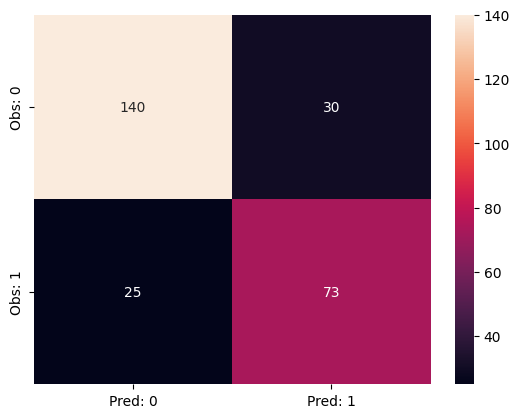

              precision    recall  f1-score   support

           0       0.85      0.82      0.84       170
           1       0.71      0.74      0.73        98

    accuracy                           0.79       268
   macro avg       0.78      0.78      0.78       268
weighted avg       0.80      0.79      0.80       268



0.7955087719298245

In [337]:
mod_lg, acc_lg = rand_search(model = LogisticRegression(), params = params_lg, df = new_en_data)
acc_lg

#### 2. Decision Tree

In [338]:
params_dt = {
    'criterion': ['gini','entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [3, 6, 9],
    'min_samples_leaf': [5, 8, 11],
    'max_features': ['sqrt', 'log2'],
}

Counter({1: 379, 0: 379})


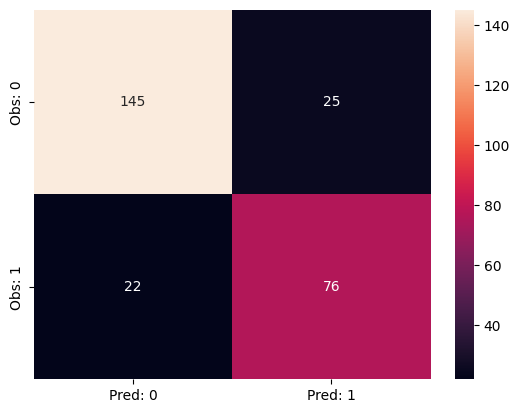

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       170
           1       0.75      0.78      0.76        98

    accuracy                           0.82       268
   macro avg       0.81      0.81      0.81       268
weighted avg       0.83      0.82      0.83       268



0.7810701754385965

In [339]:
mod_dt, acc_dt = rand_search(model = DecisionTreeClassifier(), params = params_dt, df = new_en_data)
acc_dt

#### 3. Random Forest Classifier

In [340]:
rf_params = {
    'n_estimators': [10, 50, 100, 150, 200],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [10, 15, 20, 25, 40],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'oob_score': [True],
}

Counter({1: 379, 0: 379})


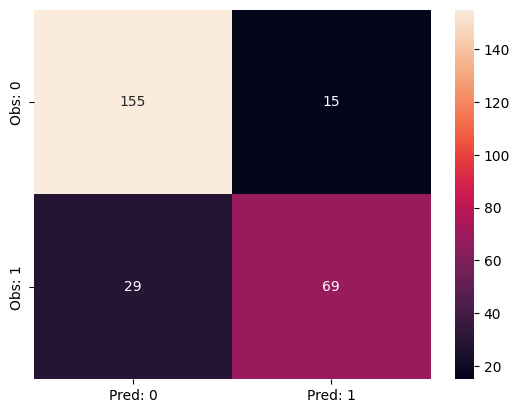

              precision    recall  f1-score   support

           0       0.84      0.91      0.88       170
           1       0.82      0.70      0.76        98

    accuracy                           0.84       268
   macro avg       0.83      0.81      0.82       268
weighted avg       0.83      0.84      0.83       268



0.831280701754386

In [341]:
mod_rf, acc_rf = rand_search(model = RandomForestClassifier(), params = rf_params, df = new_en_data)
acc_rf

#### 4. KNN Classification

In [342]:
params_knn = {
    'n_neighbors': [1, 3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p':[0,1,2,'i']
}

Counter({1: 379, 0: 379})


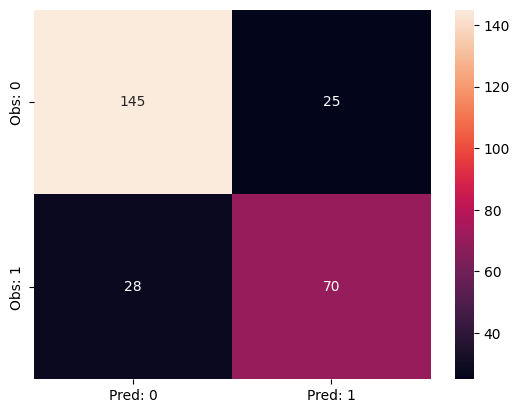

              precision    recall  f1-score   support

           0       0.84      0.85      0.85       170
           1       0.74      0.71      0.73        98

    accuracy                           0.80       268
   macro avg       0.79      0.78      0.79       268
weighted avg       0.80      0.80      0.80       268



0.8048421052631578

In [343]:
mod_knn, acc_knn = rand_search(model = KNeighborsClassifier(), params = params_knn, df = new_en_data)
acc_knn

Any type of sampling done is resulting in worse accuracy than the original.

#### 5. Naive Bayes

In [344]:
params_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

Counter({1: 379, 0: 379})


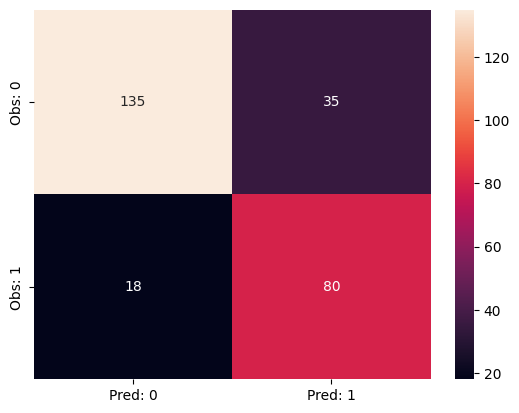

              precision    recall  f1-score   support

           0       0.88      0.79      0.84       170
           1       0.70      0.82      0.75        98

    accuracy                           0.80       268
   macro avg       0.79      0.81      0.79       268
weighted avg       0.81      0.80      0.80       268



0.7823333333333333

In [345]:
mod_nb, acc_nb = rand_search(model = GaussianNB(), params= params_nb, df = new_en_data)
acc_nb

#### 6. SVC

In [346]:
params_svc = {
    'C': [0.1, 1, 10, 15, 20],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'decision_function_shape': ['ovo','ovr']
}

Counter({1: 379, 0: 379})


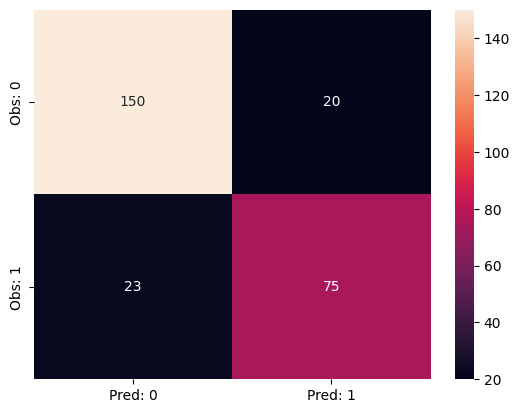

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       170
           1       0.79      0.77      0.78        98

    accuracy                           0.84       268
   macro avg       0.83      0.82      0.83       268
weighted avg       0.84      0.84      0.84       268



0.8140350877192983

In [347]:
mod_svc, acc_svc = rand_search(model = SVC(), params = params_svc, df = new_en_data)
acc_svc

In [348]:
mod = [mod_dt, mod_knn, mod_lg, mod_nb, mod_rf, mod_svc]

#### 7. Bagging Classifier

In [349]:
params_bg = {
    'base_estimator': mod,
    'n_estimators': [10, 20, 30, 40, 50],
}

Counter({1: 379, 0: 379})


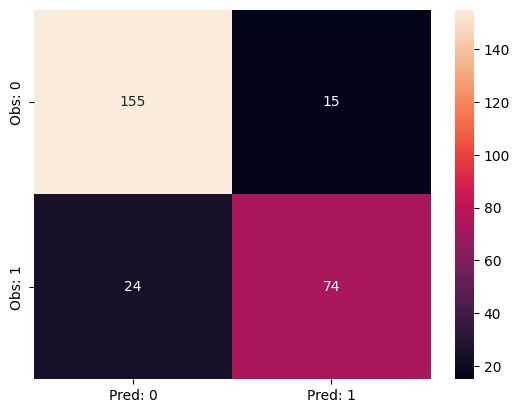

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       170
           1       0.83      0.76      0.79        98

    accuracy                           0.85       268
   macro avg       0.85      0.83      0.84       268
weighted avg       0.85      0.85      0.85       268



0.8299298245614036

In [350]:
mod_bg, acc_bg = rand_search(model = BaggingClassifier(), params = params_bg, df = new_en_data)
acc_bg 

#### 8. Ada Boost

In [351]:
params_ada = {
    'base_estimator': mod,
    'n_estimators': [40, 50, 60, 70, 80, 90],
    'algorithm': ['SAMME', 'SAMME.R']
}

Counter({1: 379, 0: 379})


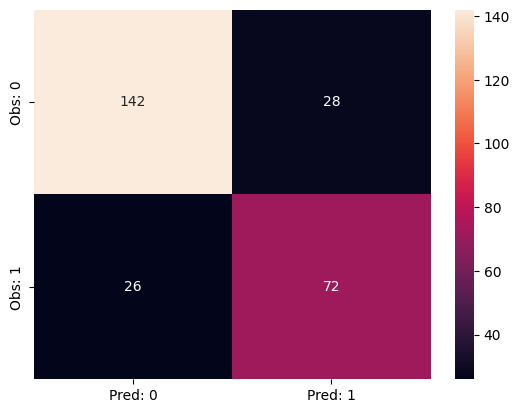

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       170
           1       0.72      0.73      0.73        98

    accuracy                           0.80       268
   macro avg       0.78      0.78      0.78       268
weighted avg       0.80      0.80      0.80       268



0.8379298245614034

In [352]:
mod_ada, acc_ada = rand_search(model = AdaBoostClassifier(), params = params_ada, df = new_en_data)
acc_ada